In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
import networkx as nx

from models import GraphRegressionGraphTransformer, GraphRegressionGraphTransformerEdges, GraphRegressionGraphTransformerEdgesCustom
from preprocess import AddLaplacianPosEncoding, ZINCDataset, AddWLPosEncoding
from train import train_one_epoch, evaluate

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


# Parameters

In [3]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 6

# Training parameters
BATCH_SIZE = 128
INIT_LR = 0.0007
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 15
MIN_LR = 1e-6
EPOCHS = 300

# Network parameters
n_hidden = 80
n_head = 8
n_feedforward = 160
n_layers = 10
input_dropout = 0.0
dropout = 0.0
norm = 'batch'
readout = 'mean'
pos_encoding = 'both'

# Data

In [4]:
# Dataset and prior transforms
data_transforms = T.Compose([
    ZINCDataset(),
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    AddWLPosEncoding(),
    T.AddSelfLoops('edge_attr')
    ])


dataset_train = ZINC('data/ZINC', subset=True, split='train', pre_transform=data_transforms)
dataset_val = ZINC('data/ZINC', subset=True, split='val', pre_transform=data_transforms)
dataset_test = ZINC('data/ZINC', subset=True, split='test', pre_transform=data_transforms)

In [5]:
# Dataloaders
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = torch_geometric.loader.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = torch_geometric.loader.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Vocabulary sizes for nodes and edges, for embedding layers
n_nodes_input = torch.unique(dataset_train.x).size(0)
n_edges_input = torch.unique(dataset_train.edge_attr).size(0)+1

# Training and test

In [7]:
checkpoint_path = 'checkpoints/ZINC_500kcustom_batch_300.pth'

"""model = GraphRegressionGraphTransformerEdges(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding=pos_encoding, 
                                             norm=norm,
                                             readout = readout)"""

"""model = GraphRegressionGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             pos_encoding=pos_encoding,
                                             norm=norm,
                                             readout = readout)"""

model = GraphRegressionGraphTransformerEdgesCustom(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding=pos_encoding, 
                                             norm=norm,
                                             readout = readout)

#model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=LR_REDUCE_FACTOR,
                                                 patience=PATIENCE,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
epoch_train_accs, epoch_val_accs = [], [] 

In [9]:
for epoch in range(EPOCHS):
    
    epoch_train_loss, optimizer = train_one_epoch(model, dataloader_train, epoch, device, optimizer, criterion, pos_encoding=pos_encoding)

    epoch_val_loss = evaluate(model, dataloader_val, device, criterion, pos_encoding=pos_encoding) 

    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)

    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{EPOCHS}: Train loss = {epoch_train_loss:.4f}, Validation loss = {epoch_val_loss:.4f}, Learning rate = {lr}')

torch.save(model.state_dict(), checkpoint_path)

Epoch 300/300: Train loss = 1.1514, Validation loss = 1.1698, Learning rate = 0.0007


In [10]:
epoch_test_loss = evaluate(model, dataloader_test, device, criterion, pos_encoding=pos_encoding)
epoch_test_loss

1.2063032537698746

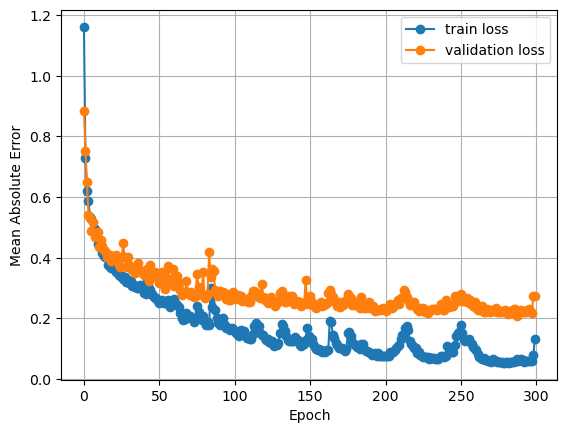

In [19]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid()

In [15]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

592241

# Visualization of attention

In [67]:
dataloader_vis = torch_geometric.loader.DataLoader(dataset_test[:3], batch_size=1, shuffle=True)

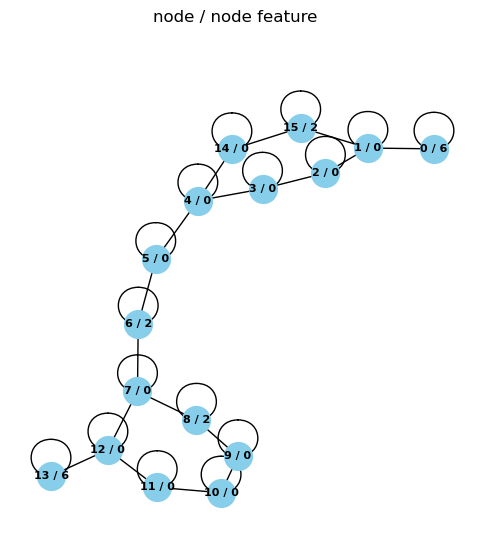

DataBatch(x=[16], edge_index=[2, 50], edge_attr=[50], y=[1], laplacian_eigs=[16, 6], wl_encoding=[16], batch=[16], ptr=[2])

In [68]:
g = next(iter(dataloader_vis))
def draw_graph(g):
    # Convert PyG graph to NetworkX graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(range(g.num_nodes))
    nx_graph.add_edges_from(g.edge_index.t().tolist())

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle('node / node feature')

    # Draw the graph with node features as labels
    pos = nx.spring_layout(nx_graph)  # You can use other layout algorithms as well
    nx.draw(nx_graph, pos, with_labels=True, 
            labels={i: f'{i} / {g.x[i].item()}' for i in range(g.num_nodes)}, 
            font_size=8, font_color='black', node_size=400, 
            node_color='skyblue', font_weight='bold', ax=ax)

    # Show the plot
    plt.show()

draw_graph(g)
g.to(device)
g

In [69]:
out, attention_scores = model(g, g.x, g.laplacian_eigs)

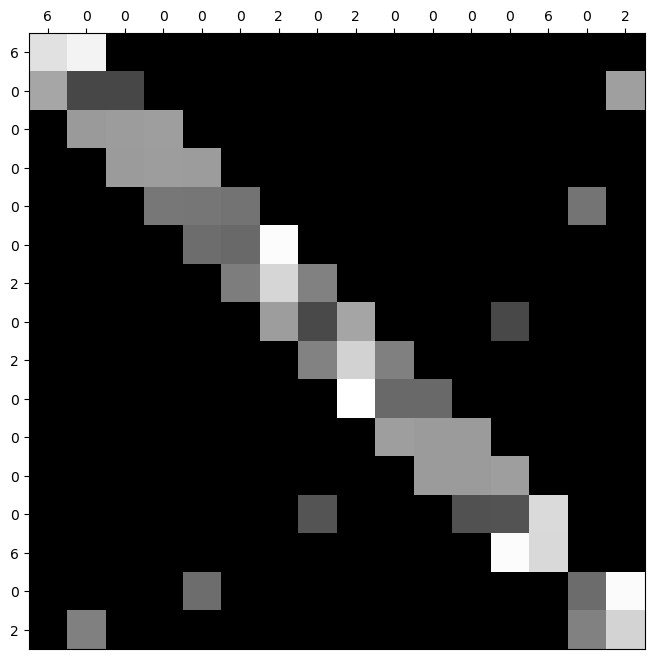

In [70]:
layer = 0
head = 5
attention_layer = attention_scores[layer]
att_plot = attention_layer[0].mean(axis=0)
#att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()


In [116]:
checkpoint_path = 'checkpoints/ZINC_edges.pth'

model2 = GraphRegressionGraphTransformerEdges(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding='laplacian', 
                                             norm=norm,
                                             readout = readout)

model2.load_state_dict(torch.load(checkpoint_path))
model2 = model2.to(device)

In [117]:
out, attention_scores2 = model2(g, g.x, g.laplacian_eigs)

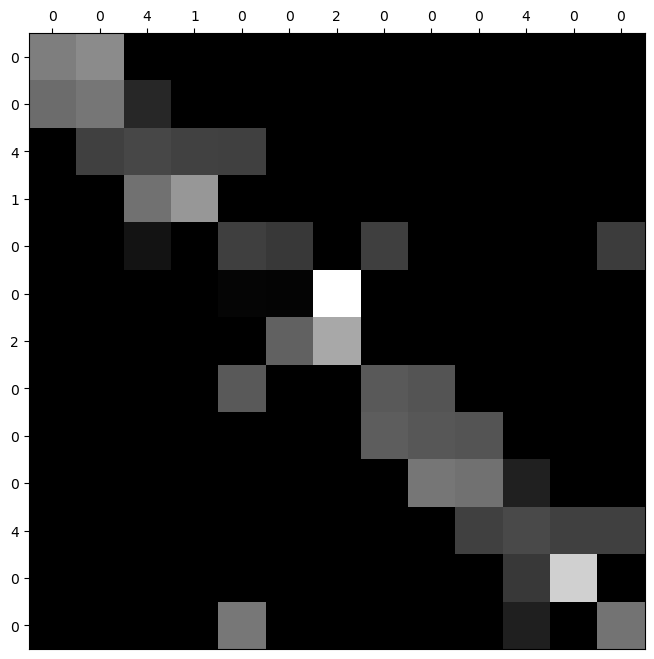

In [131]:
attention_layer = attention_scores2[layer]
#att_plot = attention_layer[0].mean(axis=0)
att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()

In [51]:
checkpoint_path = 'checkpoints/ZINC_noedges.pth'

model3 = GraphRegressionGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             pos_encoding='laplacian',
                                             norm=norm,
                                             readout = readout)

model3.load_state_dict(torch.load(checkpoint_path))
model3 = model3.to(device)

In [52]:
out, attention_scores3 = model3(g, g.x, g.laplacian_eigs)

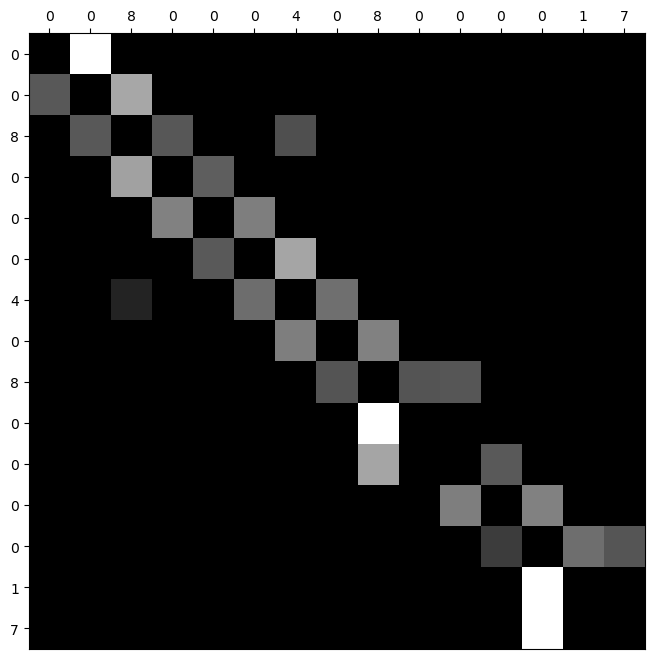

In [53]:
attention_layer = attention_scores3[layer]
#att_plot = attention_layer[0].mean(axis=0)
att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()